In [1]:
import os
from helper import get_openai_api_key
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Optional, List, Dict, Any
import operator
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from IPython.display import Image
import pandas as pd
import json

memory = MemorySaver()
openai_api_key = get_openai_api_key()

In [2]:
from chromadb import PersistentClient
from chromadb.config import Settings
import chromadb

# Ensure database directory exists
os.makedirs("database", exist_ok=True)

# Initialize ChromaDB client with reset enabled
chroma_client = chromadb.PersistentClient(
    path="database/products_db",  # Your persistence directory
    settings=Settings(allow_reset=True)  # Enable reset functionality
)

# Reset the database
chroma_client.reset()
print("ChromaDB has been reset.")

ChromaDB has been reset.


In [3]:
class AgentState(TypedDict):
    user_input: str
    file_paths: Optional[List[str]]
    file_processing: bool
    extracted_data: Optional[List[dict]]
    embedding_status: Optional[str]
    search_result: Optional[List[dict]]
    # search_table: Optional[str]
    # final_answer: Optional[Dict]
    final_answer: Optional[List[Dict[str, Any]]] 
    error: Optional[str]

def extract_products_node(state: AgentState) -> dict:
    if not state["file_processing"]:
        return {}

    try:
        print("\n🔹 [extract_products_node] Processing Excel files:", state["file_paths"])
        all_data = []

        for path in state["file_paths"]:
            df = pd.read_excel(path)
            df.columns = [col.strip() for col in df.columns if col.strip()]
            rows = df.to_dict(orient="records")
            all_data.append({"file": path, "rows": rows})

        # print("\n✅ [extract_products_node] Final Extracted Data:", all_data)
        return {"extracted_data": all_data}

    except Exception as e:
        print("\n❌ [extract_products_node] Error:", e)
        return {"error": f"Extraction failed: {str(e)}"}

def embed_products_node(state: AgentState) -> dict:
    from langchain_chroma import Chroma
    from langchain_openai import OpenAIEmbeddings

    if not state["file_processing"]:
        return {}

    try:
        rows = []
        for group in state["extracted_data"]:
            rows.extend(group["rows"])

        documents = [json.dumps(row) for row in rows]

        vector_db = Chroma(
            client=chroma_client,
            collection_name="product_data",
            embedding_function=OpenAIEmbeddings(model="text-embedding-3-large")
        )
        vector_db.add_texts(documents)

        return {"embedding_status": "done"}
    except Exception as e:
        return {"error": f"Embedding failed: {str(e)}"}

In [12]:
def search_products_node(state: AgentState) -> dict:
    from langchain_chroma import Chroma
    from langchain_openai import OpenAIEmbeddings

    try:
        vector_db = Chroma(
            client=chroma_client,
            collection_name="product_data",
            embedding_function=OpenAIEmbeddings(model="text-embedding-3-large")
        )
        results = vector_db.similarity_search(state["user_input"], k=50)
        matched_products = [json.loads(doc.page_content) for doc in results]
        print(matched_products)
        return {"search_result": matched_products}
    except Exception as e:
        return {"error": f"Search failed: {str(e)}"}


from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing import List, Dict, Any

# Define structured output schema
class ProductResponse(BaseModel):
    products: List[Dict[str, Any]] = Field(
        description="Filtered product list matching the user query"
    )

@tool(args_schema=ProductResponse)
def return_relevant_products(products: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Return relevant products extracted from the structured product data."""
    return products


def answer_node(state: AgentState) -> dict:
    from langchain_core.messages import SystemMessage, HumanMessage
    from langchain_openai import ChatOpenAI

    model = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([return_relevant_products])

    messages = [
        SystemMessage(content="""
            You are a helpful assistant that selects relevant products based on the user's query. 
            You MUST respond ONLY by calling the `return_relevant_products` tool with the list of relevant products.
            Use the provided product data and filter or rank based on what the user is asking.
            
            # Example:
            # User query: looking for decorative ceiling lights under €1000
            # Return:
            # return_relevant_products(products=[
            #   {"Product Name": "Tile Max", "Brand": "ConstructPro", "Price (€)": 551.19},
            #   {"Product Name": "LightAir Pro", "Brand": "BrightSpace", "Price (€)": 722.99}
            # ])
        """),
        HumanMessage(content=f"User query: {state['user_input']}\n\nProduct data: {json.dumps(state['search_result'], indent=2)}")
    ]

    response = model.invoke(messages)
    print("\n📥 Final Answer (Tool Call):\n", response)

    try:
        tool_call = response.tool_calls[0]
        args = tool_call['args'] if isinstance(tool_call['args'], dict) else {}
        return {"final_answer": args.get("products", [])}
    except Exception as e:
        return {"final_answer": [{"error": f"Failed to parse tool call: {str(e)}", "raw": str(response)}]}



# !!!+++ WORKING IMPLEMENTATION WITHOUT TOOL-CALLING +++!!!

# def answer_node(state: AgentState) -> dict:
#     from langchain_core.messages import SystemMessage, HumanMessage
#     from langchain_openai import ChatOpenAI

#     model = ChatOpenAI(model="gpt-4o", temperature=0)

#     messages = [
#         SystemMessage(content="""
#             You are a helpful assistant. Based on the user's query and the structured product data, return only the information relevant to the user query. 
#             Format the result as a clean JSON response with only the necessary fields!

#             **IMPORTANT: remove `json` and all backticks from the output**
#             Output example:
#             [
#                 {
#                     "Product Name": "Tile Plus",
#                     "Brand": "ConstructPro",
#                     "Price (€)": 8807.0
#                 },
#                 {
#                     "Product Name": "Tile Max",
#                     "Brand": "ConstructPro",
#                     "Price (€)": 5512.19
#                 },
#             ]

#             Output format:
#             [{..},{..},{..},  ]
#             """),

            
#         HumanMessage(content=f"User query: {state['user_input']}\n\nProduct data: {json.dumps(state['search_result'], indent=2)}")
#     ]

#     response = model.invoke(messages)
#     print("\n📥 Final Answer (LLM):\n", response.content)

#     try:
#         final_json = json.loads(response.content)
#     except Exception:
#         final_json = {"llm_response": response.content}

#     return {"final_answer": final_json}



def next_step(state: AgentState) -> str:
    if state.get("file_processing"):
        return "extract"
    else:
        return "search"

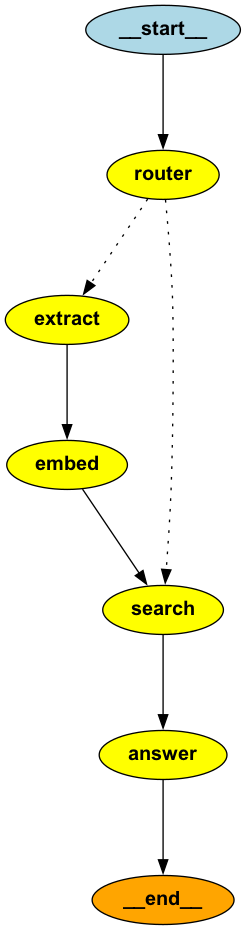

In [13]:
def build_price_comparison_graph():
    builder = StateGraph(AgentState)

    builder.add_node("router", lambda state: {})
    builder.add_node("extract", extract_products_node)
    builder.add_node("embed", embed_products_node)
    builder.add_node("search", search_products_node)
    builder.add_node("answer", answer_node)

    builder.add_edge("extract", "embed")
    builder.add_edge("embed", "search")
    builder.add_edge("search", "answer")
    builder.add_edge("answer", END)

    builder.add_conditional_edges(
        "router",
        next_step,
        {"extract": "extract", "search": "search"}
    )

    # builder.set_entry_point("extract")
    # builder.set_entry_point("search")
    builder.add_edge(START, "router")


    return builder

builder = build_price_comparison_graph()
workflow = builder.compile(checkpointer=MemorySaver())
Image(workflow.get_graph().draw_png())

In [14]:
def run_price_agent(user_input: str, file_processing: bool = True, file_paths: Optional[List[str]] = None) -> AgentState:
    global workflow

    state: AgentState = {
        "user_input": user_input,
        "file_paths": file_paths if file_processing else None,
        "file_processing": file_processing,
        "extracted_data": None,
        "embedding_status": None,
        "search_result": None,
        "final_answer": None,
        "error": None
    }

    thread = {"configurable": {"thread_id": "1"}}
    return workflow.invoke(state, thread)


state = run_price_agent(
    user_input="Get all drill tools, including the german ones and their prices. Merge the table to list the german and english name under Product.",
    file_processing=False,
    file_paths=["construction_products_english.xlsx", "construction_products_german.xlsx"]
)


# Convert full search_result JSON to DataFrame with all unique keys as columns
if state.get("final_answer"):
    df = pd.DataFrame(state["final_answer"])
    display(df)
else:
    print("No search results to display.")

# Optional: print full state for inspection
# print(json.dumps(state, indent=2))

# if state.get("final_answer") and isinstance(state["final_answer"], list):
#     df = pd.DataFrame(state["final_answer"])
#     display(df)
# else:
#     print(" No valid tabular data to display.")


[{'Referenznummer': 'PRD10001Z', 'Produktname': 'Bohrer', 'Marke': 'DuraBuild', 'Serie': 'Ultra', 'Kategorie': 'Werkzeuge', 'Material': 'Holz', 'Abmessungen (mm)': '2019 x 495 x 440', 'Gewicht (kg)': 1142.7, 'Preis (€)': 3820.97, 'Lagerbestand': 108, 'Garantie (Jahre)': 17, 'Energiebewertung': 'D', 'Installationstyp': 'Permanent', 'Zertifizierung': 'EnEV', 'Verfügbarkeit': '2-3 Tage'}, {'Reference Number': 'PRD10147X', 'Product Name': 'Power Drill', 'Brand': 'BuildTech', 'Series': 'Ultra', 'Category': 'Structural', 'Material': 'Wood', 'Dimensions (mm)': '4150 x 1275 x 783', 'Weight (kg)': 1365.2, 'Price (€)': 844.88, 'Stock Quantity': 464, 'Warranty (years)': 6, 'Energy Rating': 'C', 'Installation Type': 'Temporary', 'Certification': 'EnEV', 'Availability': 'Pre-Order'}, {'Reference Number': 'PRD10136D', 'Product Name': 'Power Drill Lite', 'Brand': 'BuildTech', 'Series': 'Lightweight', 'Category': 'Tools', 'Material': 'Glass', 'Dimensions (mm)': '3952 x 1992 x 944', 'Weight (kg)': 1624

,Product,Brand,Price (€)
0,Bohrer / Drill,DuraBuild,3820.97
1,Power Drill,BuildTech,844.88
2,Power Drill Lite,BuildTech,3155.20
3,Drill Premium,ConstructPro,9817.42
4,Bohrer Elite / Drill Elite,ConstructPro,2960.29
5,Smart Drill Premium,ConstructPro,7899.19
6,Bohrer Basis / Drill Lite,MasonMaster,9322.89
7,Öko Bohrer / Eco Drill,StrucSteel,1162.39
8,Drill,DuraBuild,4938.36
9,Drill Plus,TerraBlock,1984.21
